# DQN code

In [1]:
import random
import gymnasium as gym
import numpy as np
import collections
from tqdm import tqdm
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils

In [2]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*transitions)
        return np.array(state), np.array(action, dtype=np.int64), np.array(reward), np.array(next_state), np.array(done, dtype=np.float32)

    def size(self):
        return len(self.buffer)
        
        

定义 Q-net

In [3]:
class Qnet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super().__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)
        

DQN 算法实现

In [4]:
class DQN:
    def __init__(self, state_dim, hidden_dim, action_dim, 
                 learning_rate, gamma, epsilon, target_update, device):
        self.action_dim = action_dim
        self.q_net = Qnet(state_dim, hidden_dim, action_dim).to(device)
        self.target_q_net = Qnet(state_dim, hidden_dim, action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.q_net.parameters(),lr=learning_rate)
        self.gamma = gamma
        self.epsilon = epsilon
        self.target_update = target_update
        self.count = 0
        self.device = device
        
    def take_action(self, state):  # epsilon-贪婪策略采取动作
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            state = torch.tensor([state], dtype=torch.float).to(self.device)
            action = self.q_net(state).argmax().item()
        return action
        
    def update(self, transition_dict):
        states = torch.tensor(transition_dict["states"],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict["actions"],
                               dtype=torch.long).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict["rewards"],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)
        q_values = self.q_net(states).gather(1, actions)

        # 这里采用.max(1)[0]是因为这里的max函数会返回两个东西，
        # 一个是沿着 轴（1）方向压缩得到的最大值
        # 另一个是最大值的索引
        # 这里只需要最大值，不需要索引，所以取[0]，即第一个元素
        max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1, 1)
        q_targets = rewards + self.gamma * max_next_q_values * (1-dones)
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))
        self.optimizer.zero_grad()
        dqn_loss.backward()
        self.optimizer.step()

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict())

        self.count += 1
                
        
        

In [5]:
lr = 2e-3
num_episodes = 500
hidden_dim = 128
gamma = 0.98
epsilon = 0.01
target_update = 10
buffer_size = 10000
minimal_size = 500
batch_size = 64
device = torch.device("mps") if torch.backends.mps.is_available else torch.device(
    "cpu")

env_name = 'CartPole-v1'
env = gym.make(env_name)
random.seed(0)
np.random.seed(0)
env.reset(seed=0)
torch.manual_seed(0)

replay_buffer = ReplayBuffer(buffer_size)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon, target_update, device)

return_list = []
for i in range(10):
    with tqdm(total=num_episodes / 10, desc=f"Iteration: {i}") as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            state, _ = env.reset()
            done = False
            while not done:
                action = agent.take_action(state)
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                replay_buffer.add(state, action, reward, next_state, done)
                episode_return += reward
                state = next_state
                if replay_buffer.size() > minimal_size:
                    b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                    transition_dict = {
                        'states': b_s,
                        'actions': b_a,
                        'next_states': b_ns,
                        'rewards': b_r,
                        'dones': b_d
                    }
                    agent.update(transition_dict)
            return_list.append(episode_return)    
            if (i_episode+1) % 10 == 0:
                pbar.set_postfix(
                    {
                        "episode": i * num_episodes / 10 + i_episode + 1,
                        "return": "{:.3f}".format(np.mean(return_list[-10:]))
                    }
                )
            pbar.update(1)

Iteration: 0:   0%|          | 0/50.0 [00:00<?, ?it/s]/var/folders/mm/1cxc88791zqf8gynh3j4qjr40000gn/T/ipykernel_67729/2482788410.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:256.)
  state = torch.tensor([state], dtype=torch.float).to(self.device)
Iteration: 0: 100%|██████████| 50/50.0 [00:00<00:00, 166.33it/s, episode=50, return=9.000]
Iteration: 1: 100%|██████████| 50/50.0 [00:01<00:00, 29.16it/s, episode=100, return=14.500]
Iteration: 2: 100%|██████████| 50/50.0 [00:07<00:00,  6.28it/s, episode=150, return=117.500]
Iteration: 3: 100%|██████████| 50/50.0 [00:21<00:00,  2.37it/s, episode=200, return=173.200]
Iteration: 4: 100%|██████████| 50/50.0 [00:21<00:00,  2.35it/s, episode=250, return=180.400]
Iteration: 5: 100%|██████████| 50/50

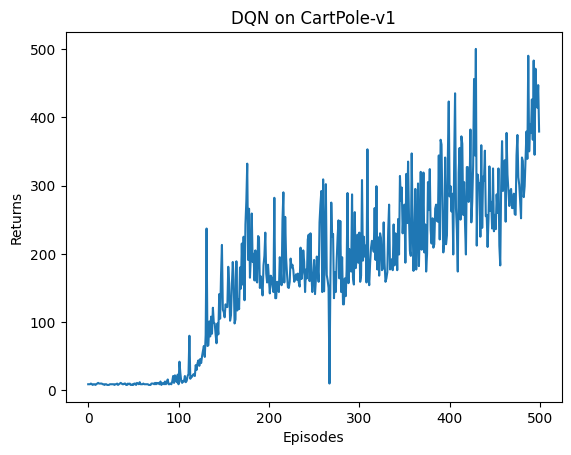

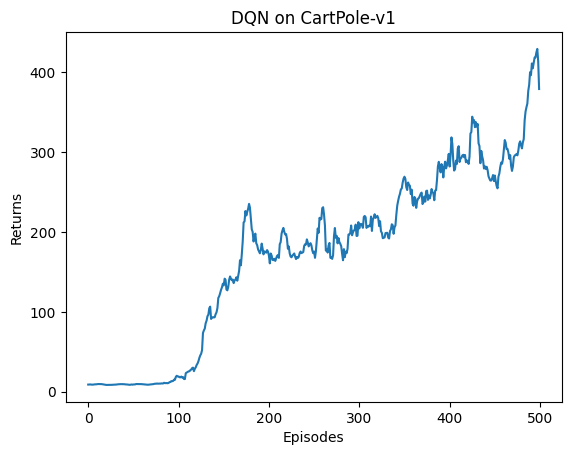

In [6]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()